# Dynamical blockade in a bosonic Josephson junction using optimal coupling

Based on paper: DOI: https://doi.org/10.1103/PhysRevA.102.013716

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from torchqc.states import QuantumState
from torchqc.common_functions import get_density_matrix, expect_val_dm
from torchqc.operators import DynamicOperator
from torchqc.common_matrices import annihilation, creation, eye
from torchqc.dynamics import lindblad_equation
from torchqc.tensor_product import tensor_product_ops, tensor_product_states
from torchqc.correlation import correlation_fn_3op_1time

* Initial state is tensor product of two coherent states of the two modes

$\ket{\psi} = \ket{a_1} \otimes \ket{a_2}$

In [8]:
N = 10 # number of fock states
total_dims = N ** 2

b1 = 0.1
b2_strong = 0.0
b2_weak = 0.015
coherent_state_1 = QuantumState.coherent(N, b1)
coherent_state_2_strong = QuantumState.coherent(N, b2_strong)
coherent_state_2_weak = QuantumState.coherent(N, b2_weak)

initial_state_strong = tensor_product_states(coherent_state_1, coherent_state_2_strong)
initial_state_weak = tensor_product_states(coherent_state_1, coherent_state_2_weak)

* Simulate dynamics

In [9]:
T_strong = 3.1
T_weak = 1.6
Dt = 0.01

k = 1
w = 0.1  # modes frequency
U_strong = 1 * k  # nonlinear coupling
U_weak = 0.02 * np.pi * k
J_strong = 5 * k
J_weak = np.pi * k

time_strong = np.arange(0, T_strong, Dt)
time_weak = np.arange(0, T_weak, Dt)

* Hamiltonian of a bosonic Josephson junctions with two quantized modes (Bos-Hubband approximation)

$H = \sum_{i = 1}^2[\hslash \omega \hat{a}_i^{\dagger}\hat{a}_i + \hslash U\hat{a}_i^{\dagger}\hat{a}_i^{\dagger}\hat{a}_i\hat{a}_i] + \hslash J(t)(\hat{a}_1^{\dagger}\hat{a}_2 + \hat{a}_1\hat{a}_2^{\dagger}),$

In [10]:
a1_dagger = tensor_product_ops(creation(N), eye(N))
a2_dagger = tensor_product_ops(eye(N), creation(N))

a_1 = tensor_product_ops(annihilation(N), eye(N))
a_2 = tensor_product_ops(eye(N), annihilation(N))

N1 = a1_dagger * a_1
N2 = a2_dagger * a_2

H1 = w * N1 + w * N2
H2_strong = U_strong * a1_dagger * a1_dagger * a_1 * a_1 + U_strong * a2_dagger * a2_dagger * a_2 * a_2
H2_weak = U_weak * a1_dagger * a1_dagger * a_1 * a_1 + U_weak * a2_dagger * a2_dagger * a_2 * a_2
H3_strong = J_strong * (a1_dagger * a_2 + a_1 * a2_dagger)
H3_weak = J_weak * (a1_dagger * a_2 + a_1 * a2_dagger)

H_strong = H1 + H2_strong + H3_strong
H_weak = H1 + H2_weak + H3_weak

In [11]:
hamiltonian_strong = DynamicOperator(total_dims, H_strong, time=time_strong)
hamiltonian_weak = DynamicOperator(total_dims, H_weak, time=time_weak)

* Simulate dynamics with von-Neumann equations

In [12]:
rho_strong = get_density_matrix(initial_state_strong)
rho_weak = get_density_matrix(initial_state_weak)

jump_ops = [a_1, a_2]
rates = [k, k]

_, strong_states = lindblad_equation(rho_strong, hamiltonian_strong, time_strong, Dt, jump_ops, rates)
_, weak_states = lindblad_equation(rho_weak, hamiltonian_weak, time_weak, Dt, jump_ops, rates)

In [13]:
expectation_values_N1_strong = expect_val_dm(strong_states, N1)
expectation_values_N1_weak = expect_val_dm(weak_states, N1)

In [ ]:
G2_1_strong = np.array(
    [correlation_fn_3op_1time(None, rho, None, Dt, 
                a1_dagger, a1_dagger * a_1, a_1, None, None) 
        for rho in strong_states]
    )
g2_1_strong = G2_1_strong / (expectation_values_N1_strong ** 2)

G2_1_weak = np.array([correlation_fn_3op_1time(None, rho, None, Dt, 
                a1_dagger, a1_dagger * a_1, a_1, None, None) 
        for rho in weak_states])
g2_1_weak = G2_1_weak / (expectation_values_N1_weak ** 2)

Text(0.5, -0.5, '(c)')

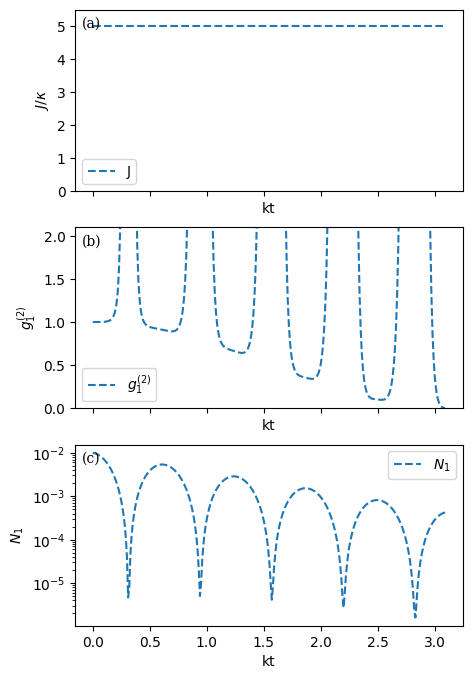

In [15]:
fig, axs = plt.subplots(3, 1, sharex='col')

fig.set_figheight(8)
fig.set_figwidth(5)

pulse_fig = axs[0]
corr_fig = axs[1]
pop_fig = axs[2]

pulse_fig.plot(time_strong, np.full(len(time_strong), J_strong), linestyle='--', label=r"J")
pulse_fig.set_ylabel(r"$J / \kappa$")
pulse_fig.set_xlabel("kt")
pulse_fig.set_ylim(0, 5.5)
pulse_fig.legend()

pulse_fig.annotate(
        "(a)",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',)

corr_fig.plot(time_strong, g2_1_strong, linestyle='--', label=r"$g^{(2)}_1$")
corr_fig.set_xlabel("kt")
corr_fig.set_ylabel(r"$g^{(2)}_1$")
corr_fig.set_ylim(0, 2.1)
corr_fig.legend()
corr_fig.annotate(
        "(b)",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',)

pop_fig.plot(time_strong, expectation_values_N1_strong, linestyle='--', label=r"$N_1$")
pop_fig.set_xlabel("kt")
pop_fig.set_ylabel(r"$N_1$")
pop_fig.set_yscale("log")
pop_fig.legend()

pop_fig.annotate(
        "(c)",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',)

Text(0.5, -0.5, '(c)')

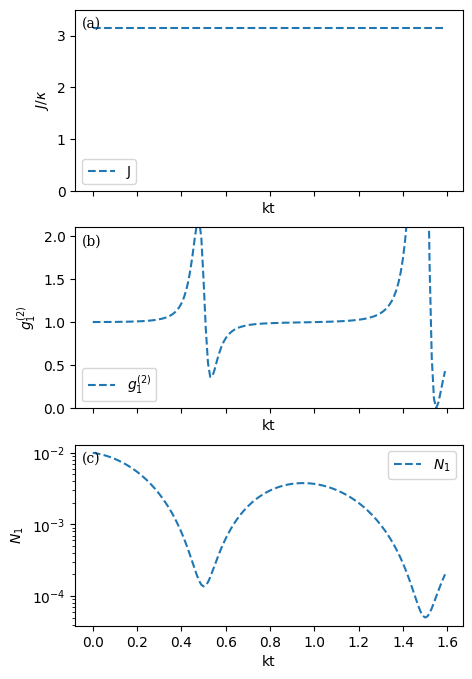

In [16]:
fig, axs = plt.subplots(3, 1, sharex='col')

fig.set_figheight(8)
fig.set_figwidth(5)

pulse_fig = axs[0]
corr_fig = axs[1]
pop_fig = axs[2]

pulse_fig.plot(time_weak, np.full(len(time_weak), J_weak), linestyle='--', label=r"J")
pulse_fig.set_ylabel(r"$J / \kappa$")
pulse_fig.set_xlabel("kt")
pulse_fig.set_ylim(0, 3.5)
pulse_fig.legend()

pulse_fig.annotate(
        "(a)",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',)

corr_fig.plot(time_weak, g2_1_weak, linestyle='--', label=r"$g^{(2)}_1$")
corr_fig.set_xlabel("kt")
corr_fig.set_ylabel(r"$g^{(2)}_1$")
corr_fig.set_ylim(0, 2.1)
corr_fig.legend()
corr_fig.annotate(
        "(b)",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',)

pop_fig.plot(time_weak, expectation_values_N1_weak, linestyle='--', label=r"$N_1$")
pop_fig.set_xlabel("kt")
pop_fig.set_ylabel(r"$N_1$")
pop_fig.set_yscale("log")
pop_fig.legend()

pop_fig.annotate(
        "(c)",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',)